<a href="https://colab.research.google.com/github/Dare-Badejo-001/Optimization-Problems/blob/main/Recharging_Strategy_For_EV_Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null

solver = 'appsi_highs'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.gdp as gdp

# specify number of charging stations
n_charging_stations = 20

# randomly distribute charging stations along a fixed route
np.random.seed(2023)
d = np.round(np.cumsum(np.random.triangular(20, 150, 223, n_charging_stations)), 1)

# randomly assign changing rates to the charging stations
c = np.random.choice([50, 100, 150, 250], n_charging_stations, p=[0.2, 0.4, 0.3, 0.1])

# assign names to the charging stations
s = [f"S{i:02d}" for i in range(n_charging_stations)]

stations = pd.DataFrame([s, d, c]).T
stations.columns = ["name", "location", "kW"]
display(stations)

,name,location,kW
0,S00,112.2,100
1,S01,294.9,100
2,S02,439.5,100
3,S03,517.3,100
4,S04,598.3,50
5,S05,729.5,50
6,S06,773.6,100
7,S07,933.0,50
8,S08,1070.7,100
9,S09,1210.6,250


In [ ]:
# Route Information

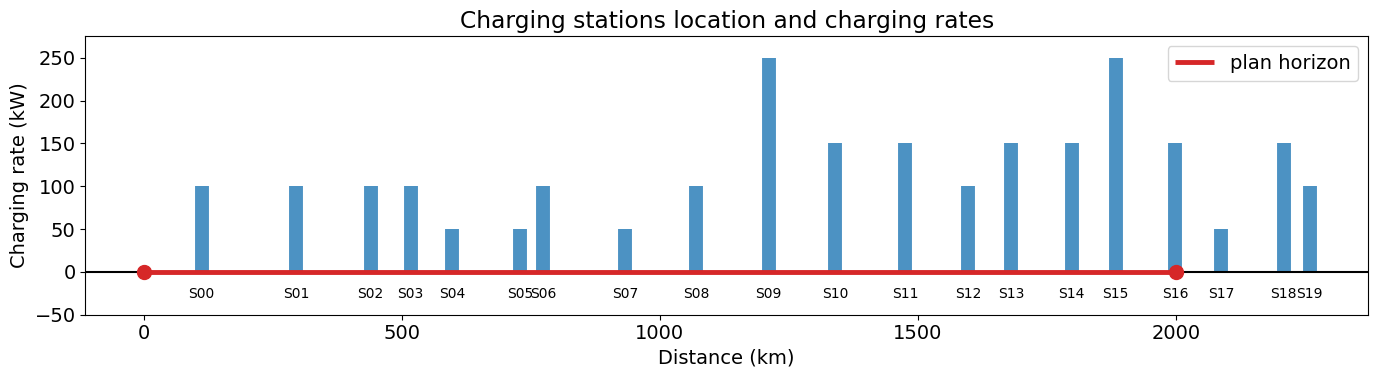

In [ ]:
# current location (km)
x = 0

# planning horizon
D = 2000

plt.rcParams.update({"font.size": 14})
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

tab20 = plt.get_cmap("tab20", 20)
colors = [tab20(i) for i in [0, 2, 4, 6]]


def plot_stations(stations, x, D, ax):
    for station in stations.index:
        xs = stations.loc[station, "location"]
        ys = stations.loc[station, "kW"]
        ax.plot(
            [xs, xs], [0, ys], color=colors[0], lw=10, solid_capstyle="butt", alpha=0.8
        )
        ax.text(xs, 0 - 30, stations.loc[station, "name"], ha="center", fontsize=10)

    ax.axhline(0, color="k")
    ax.plot(
        [x, x + D],
        [0, 0],
        color=colors[3],
        lw=3.5,
        solid_capstyle="butt",
        label="plan horizon",
    )
    ax.plot([x, x + D], [0, 0], ".", color=colors[3], ms=20)

    ax.set_ylim(-50, 275)
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("Charging rate (kW)")
    ax.set_title("Charging stations location and charging rates")
    ax.legend()


plot_stations(stations, x, D, ax)
plt.tight_layout()
plt.show()

In [ ]:
# Car Information

In [ ]:
# charge limits (kWh)
c_max = 150
c_min = 0.2 * c_max

# starting battery level (full charge)
c = c_max

# velocity km/hr and discharge rate kWh/km
v = 100.0
R = 0.24

# lost time
t_lost = 10 / 60
t_rest = 20 / 60

# rest time
r_max = 3

In [ ]:
# Pyomo Model


In [ ]:
def ev_plan(stations, x, D):

    m = pyo.ConcreteModel("Recharging EV strategy")

    m.D = D

    # find stations between x and x + D
    on_route = stations[(stations["location"] >= x) & (stations["location"] <= x + m.D)]
    m.n = pyo.Param(default=len(on_route))

    # locations and road segments between location x and x + D
    m.STATIONS = pyo.RangeSet(1, m.n)
    m.LOCATIONS = pyo.RangeSet(0, m.n + 1)
    m.SEGMENTS = pyo.RangeSet(1, m.n + 1)

    # distance traveled
    m.x = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, 10000))

    # arrival and departure charge at each charging station
    m.c_arr = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(c_min, c_max))
    m.c_dep = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(c_min, c_max))

    # arrival and departure times from each charging station
    m.t_arr = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, 100))
    m.t_dep = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, 100))

    # arrival and departure rest from each charging station
    m.r_arr = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, r_max))
    m.r_dep = pyo.Var(m.LOCATIONS, domain=pyo.NonNegativeReals, bounds=(0, r_max))

    # initial conditions
    m.x[0].fix(x)
    m.t_dep[0].fix(0.0)
    m.r_dep[0].fix(0.0)
    m.c_dep[0].fix(c)

    @m.Param(m.STATIONS)
    def C(m, i):
        return on_route.loc[i - 1, "kW"]

    @m.Param(m.LOCATIONS)
    def location(m, i):
        if i == 0:
            return x
        elif i == m.n + 1:
            return x + m.D
        else:
            return on_route.loc[i - 1, "location"]

    @m.Param(m.SEGMENTS)
    def dist(m, i):
        return m.location[i] - m.location[i - 1]

    @m.Objective(sense=pyo.minimize)
    def min_time(m):
        return m.t_arr[m.n + 1]

    @m.Constraint(m.SEGMENTS)
    def drive_time(m, i):
        return m.t_arr[i] == m.t_dep[i - 1] + m.dist[i] / v

    @m.Constraint(m.SEGMENTS)
    def rest_time(m, i):
        return m.r_arr[i] == m.r_dep[i - 1] + m.dist[i] / v

    @m.Constraint(m.SEGMENTS)
    def drive_distance(m, i):
        return m.x[i] == m.x[i - 1] + m.dist[i]

    @m.Constraint(m.SEGMENTS)
    def discharge(m, i):
        return m.c_arr[i] == m.c_dep[i - 1] - R * m.dist[i]

    @m.Disjunction(m.STATIONS, xor=True)
    def recharge(m, i):
        # list of constraints thtat apply if there is no stop at station i
        disjunct_1 = [
            m.c_dep[i] == m.c_arr[i],
            m.t_dep[i] == m.t_arr[i],
            m.r_dep[i] == m.r_arr[i],
        ]

        # list of constraints that apply if there is a stop at station i
        disjunct_2 = [
            m.t_dep[i] == t_lost + m.t_arr[i] + (m.c_dep[i] - m.c_arr[i]) / m.C[i],
            m.c_dep[i] >= m.c_arr[i] + t_rest,
            m.r_dep[i] == 0,
        ]

        # return a list disjuncts
        return [disjunct_1, disjunct_2]

    return m


m = ev_plan(stations, 0, 2000)
pyo.TransformationFactory("gdp.bigm").apply_to(m)
SOLVER.solve(m)
results = pd.DataFrame(
    {
        i: {
            "location": m.x[i](),
            "t_arr": m.t_arr[i](),
            "t_dep": m.t_dep[i](),
            "c_arr": m.c_arr[i](),
            "c_dep": m.c_dep[i](),
        }
        for i in m.LOCATIONS
    }
).T

results["t_stop"] = results["t_dep"] - results["t_arr"]
display(results)

,location,t_arr,t_dep,c_arr,c_dep,t_stop
0,0.0,NaN,0.000000,NaN,150.000000,NaN
1,112.2,1.122000,1.122000,123.072000,123.072000,1.845191e-13
2,294.9,2.949000,3.157187,79.224000,83.376000,2.081867e-01
3,439.5,4.603187,4.603187,48.672000,48.672000,-4.227729e-13
4,517.3,5.381187,6.162973,30.000000,91.512000,7.817867e-01
5,598.3,6.972973,6.972973,72.072000,72.072000,1.563194e-13
6,729.5,8.284973,8.284973,40.584000,40.584000,-7.705836e-12
7,773.6,8.725973,9.605680,30.000000,101.304000,8.797067e-01
8,933.0,11.199680,11.199680,63.048000,63.048000,1.953993e-14
9,1070.7,12.576680,13.079107,30.000000,63.576000,5.024267e-01


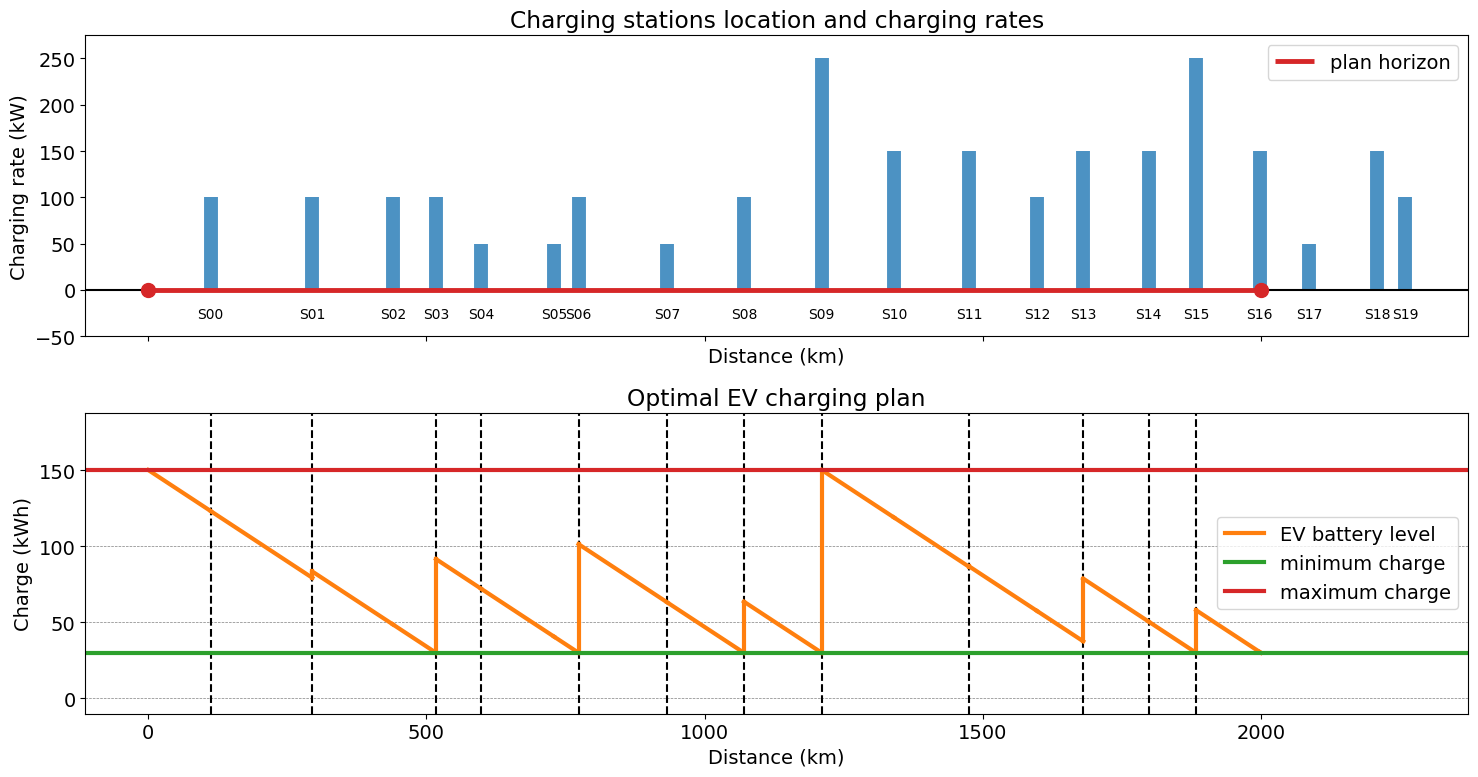

In [ ]:
def visualizeEVplan(m, results):

    fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    plot_stations(stations, x, m.D, ax[0])

    # mark stop locations
    for i in m.STATIONS:
        if results.loc[i, "t_stop"] > 0:
            ax[1].axvline(results.loc[i, "location"], color="k", ls="--", lw=1.5)

    # plot battery charge
    for i in m.SEGMENTS:
        xv = [results.loc[i - 1, "location"], results.loc[i, "location"]]
        cv = [results.loc[i - 1, "c_dep"], results.loc[i, "c_arr"]]
        if i == 1:
            ax[1].plot(xv, cv, color=colors[1], lw=3, label="EV battery level")
        else:
            ax[1].plot(xv, cv, color=colors[1], lw=3)

    # plot charge at stations
    for i in m.STATIONS:
        xv = [results.loc[i, "location"]] * 2
        cv = [results.loc[i, "c_arr"], results.loc[i, "c_dep"]]
        ax[1].plot(xv, cv, color=colors[1], lw=3)

    # show constraints on battery charge
    ax[1].axhline(c_min, c=colors[2], lw=3, label="minimum charge")
    ax[1].axhline(c_max, c=colors[3], lw=3, label="maximum charge")
    ax[1].set_ylim(-10, 1.25 * c_max)
    ax[1].set_xlabel("Distance (km)")
    ax[1].set_ylabel("Charge (kWh)")
    ax[1].set_title("Optimal EV charging plan")
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax[1].legend()
    ax[1].grid(True, axis="y", linestyle="--", linewidth=0.5, color="gray")

    plt.tight_layout()
    plt.savefig("ev_results.svg", dpi=300, bbox_inches="tight")
    plt.show()


visualizeEVplan(m, results)